In [1]:
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os


In [2]:
os.getcwd()

'/home/dices/Research/GWlensing_Brian'

In [3]:
#original logic but memory comsuming
# Name = "Abell 370"
# name = "abell370"
# data_path = f"/home/dices/Research/GWlensing_Brian/GCdata/{Name}/diego/range/"  # change this to the actual path where your FITS files are located
# #Build the file pattern
# x_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_diego-map???_v4.1_x-arcsec-deflect.fits")
# y_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_diego-map???_v4.1_y-arcsec-deflect.fits")
# file_list_x = sorted(glob.glob(x_file_pattern))
# file_list_y = sorted(glob.glob(y_file_pattern))
# N_files_x = len(file_list_x)
# N_files_y = len(file_list_y)
# print(f"Found {N_files_x} x FITS files and {N_files_y} y FITS files.")

# file_list = file_list_x
# N_files = len(file_list)

# # Read the first FITS to get dimensions
# first_map = fits.getdata(file_list[0])
# H, W = first_map.shape
# print(f"Dimensions of the potential maps: {H} x {W}")
# # Pre-allocate an array for the potentials: shape (N_files, H, W)
# potentials = np.empty((N_files, H, W))

# for i, filename in enumerate(file_list):
#     data = fits.getdata(filename)
#     if data.shape != (H, W):
#         raise ValueError(f"File {filename} has shape {data.shape}, expected ({H}, {W})")
#     potentials[i] = data


In [4]:
# original logic but memory consuming
# # pixel size (arcsec/pixel)
# dx = 0.42
# dy = 0.42

# # Load α maps: shape (N_files, H, W, 2)
# alpha_maps = np.empty((N_files, H, W, 2), dtype=np.float64)
# for i in range(N_files):
#     dx_map = fits.getdata(file_list_x[i]).astype(np.float64)
#     dy_map = fits.getdata(file_list_y[i]).astype(np.float64)
#     alpha_maps[i] = np.stack((dx_map, dy_map), axis=-1)

# # Ensemble mean of components
# alpha_mean = np.mean(alpha_maps, axis=0)                # (H, W, 2)
# alpha_mean_mag = np.linalg.norm(alpha_mean, axis=-1)    # (H, W)

# # Compute |α| per map, then take sample std across the ensemble.
# alpha_mag = np.linalg.norm(alpha_maps, axis=-1)         # (N_files, H, W)
# sigma_abs = np.std(alpha_mag, axis=0, ddof=1)           # (H, W)  == σ_|α|

# # Relative uncertainty map (per pixel)
# eps = 1e-12     #avoid zeros
# relative_sigma = sigma_abs / np.maximum(alpha_mean_mag, eps)

# # Overall upper bound (84th percentile σ)
# upper_bound_fraction = np.percentile(relative_sigma, 84.0)
# upper_bound_percentage = upper_bound_fraction * 100.0
# print(f"Upper bound relative uncertainty in |alpha|: {upper_bound_percentage:.4f}%")

# # Visualization
# fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# im1 = axes[0].imshow(alpha_mean_mag, origin='lower', cmap='plasma')
# axes[0].set_title("Mean Deflection Magnitude |α|")
# plt.colorbar(im1, ax=axes[0], label="|ᾱ|")

# im2 = axes[1].imshow(relative_sigma, origin='lower', cmap='inferno', norm=LogNorm())
# axes[1].set_title("Relative σ of |α| (σ_|α| / |ᾱ|)")
# plt.colorbar(im2, ax=axes[1], label="σ_|α| / |ᾱ|")

# plt.tight_layout()
# plt.show()

# # Extract x and y components of the mean and std
# alpha_mean_x = alpha_mean[:, :, 0]
# alpha_std_x  = alpha_std[:, :, 0]

# alpha_mean_y = alpha_mean[:, :, 1]
# alpha_std_y  = alpha_std[:, :, 1]

# # Avoid division by zero
# alpha_mean_x_safe = np.where(np.abs(alpha_mean_x) < 1e-10, 1e-10, alpha_mean_x)
# alpha_mean_y_safe = np.where(np.abs(alpha_mean_y) < 1e-10, 1e-10, alpha_mean_y)

# # Relative uncertainties (per pixel) for each component:
# rel_unc_x = alpha_std_x / np.abs(alpha_mean_x_safe)
# rel_unc_y = alpha_std_y / np.abs(alpha_mean_y_safe)

# # Upper bound uncertainty (84th percentile) for each component:
# upper_bound_rel_unc_x = np.percentile(rel_unc_x, 84) * 100  # as a percentage
# upper_bound_rel_unc_y = np.percentile(rel_unc_y, 84) * 100  # as a percentage

# print(f"Upper bound relative uncertainty in α_x: {upper_bound_rel_unc_x:.2f}%")
# print(f"Upper bound relative uncertainty in α_y: {upper_bound_rel_unc_y:.2f}%")

In [5]:
# for psi uncertainty maps
Name = "Abell 2744"
name = "abell2744"
data_path = f"/home/dices/Research/GWlensing_Brian/GCdata/{Name}/cats copy/range/"
psi_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_cats-map???_v4_psi.fits")
file_list_psi = sorted(glob.glob(psi_file_pattern))
N_files_psi = len(file_list_psi)
print(f"Found {N_files_psi} psi FITS files.")

# --- 2. Get dimensions from the first file ---
# You only need to do this once.
first_map = fits.getdata(file_list_psi[0])
H, W = first_map.shape
print(f"Dimensions of the maps: {H} x {W}")


Found 200 psi FITS files.
Dimensions of the maps: 1200 x 1200


In [65]:
# --- 3. Perform the memory-efficient online calculation ---
# Initialize arrays for incremental calculation
count = 0
mean = np.zeros((H, W), dtype=np.float64)
M2 = np.zeros((H, W), dtype=np.float64)  # Sum of squares of differences from the mean

print("Starting incremental calculation...")
for filename in file_list_psi:
    data = fits.getdata(filename).astype(np.float64)
    if data.shape != (H, W):
        raise ValueError(f"File {filename} has shape {data.shape}, expected ({H}, {W})")
    
    count += 1
    delta = data - mean
    mean += delta / count
    delta2 = data - mean  # New delta with updated mean
    M2 += delta * delta2

print("Calculation finished.")

# Finalize the statistics
if count < 2:
    sigma_abs = np.zeros((H, W), dtype=np.float64)
else:
    variance = M2 / (count - 1)  # ddof=1 for sample standard deviation
    sigma_abs = np.sqrt(variance)

# Assign the final mean to psi_mean
psi_mean = mean

# --- 4. Calculate final results (This part is correct) ---
eps = 1e-12  # Avoid division by zero
relative_sigma = sigma_abs / np.maximum(psi_mean, eps)

upper_bound_fraction = np.percentile(relative_sigma, 84.0)
upper_bound_percentage = upper_bound_fraction * 100.0
upper_bound_absolute = np.percentile(sigma_abs, 84.0)
print(f"Upper bound relative uncertainty in |ψ|: {upper_bound_percentage:.4f}%")
print(f"Upper bound absolute uncertainty in |ψ|: {upper_bound_absolute:.4f}")

Starting incremental calculation...
Calculation finished.
Upper bound relative uncertainty in |ψ|: 1.6348%
Upper bound absolute uncertainty in |ψ|: 111.6379


In [6]:
# pixel scale
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u

h = fits.getheader(file_list_psi[0])
w = WCS(h)

# degrees/pixel along each image axis on the WCS projection plane:
deg_per_pix = proj_plane_pixel_scales(w.celestial)

# convert to arcsec/pixel
arcsec_per_pix = (deg_per_pix * u.deg).to(u.arcsec)
print(arcsec_per_pix)         # e.g. [0.396 arcsec/pix, 0.396 arcsec/pix]

[0.30015008 0.30015008] arcsec


In [67]:
#getting the alpha maps in x and y direction by differeniating the psi map
# pixel size (arcsec/pixel)
dx = 0.5
dy = 0.5

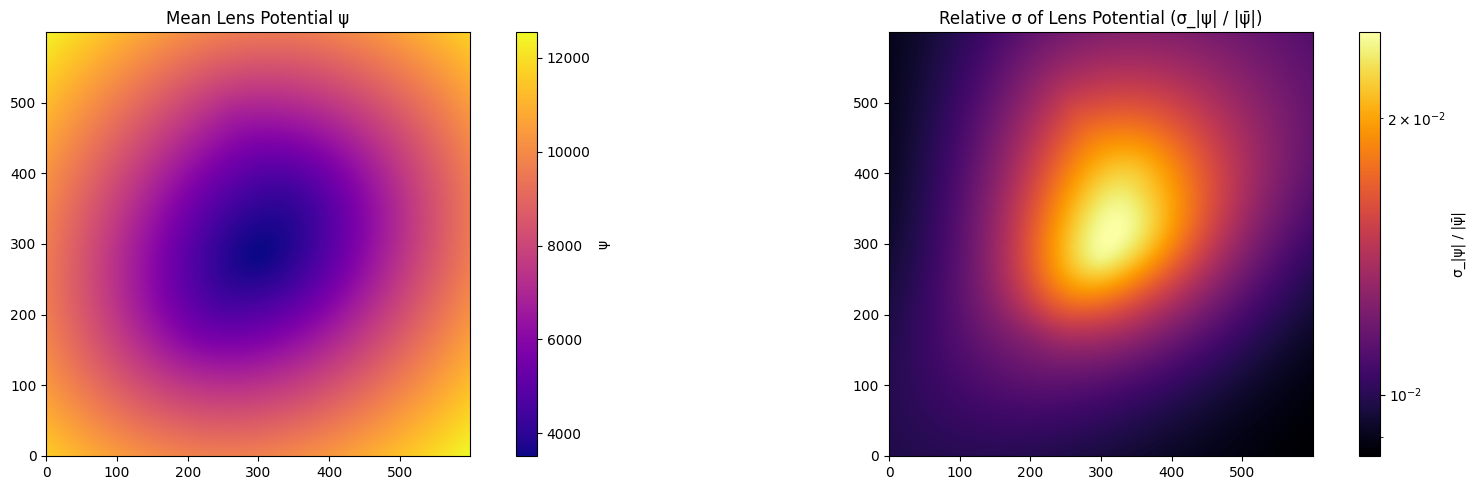

In [68]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

im1 = axes[0].imshow(psi_mean, origin='lower', cmap='plasma')
axes[0].set_title("Mean Lens Potential ψ")
plt.colorbar(im1, ax=axes[0], label="ψ")

im2 = axes[1].imshow(relative_sigma, origin='lower', cmap='inferno', norm=LogNorm())
axes[1].set_title("Relative σ of Lens Potential (σ_|ψ| / |ψ̄|)")
plt.colorbar(im2, ax=axes[1], label="σ_|ψ| / |ψ̄|")

plt.tight_layout()
plt.show()

In [69]:
# getting the uncertainty of alpha maps by differentiation

count = 0
# For the mean of the alpha vector components (ax, ay)
mean_alpha = np.zeros((H, W, 2), dtype=np.float64)
# For the standard deviation of the scalar magnitude |a|
mean_alpha_mag = np.zeros((H, W), dtype=np.float64)
M2_alpha_mag = np.zeros((H, W), dtype=np.float64)

print("Starting incremental calculation for alpha...")
for filename in file_list_psi:
    # a. Load one psi map
    psi_map = fits.getdata(filename).astype(np.float64)
    if psi_map.shape != (H, W):
        raise ValueError(f"File {filename} has shape {psi_map.shape}, expected ({H}, {W})")
    
    # b. Calculate alpha = ∇psi for this single map
    # np.gradient returns (dy, dx) so we match it to (alpha_y, alpha_x)
    alpha_y, alpha_x = np.gradient(psi_map, dy, dx)
    
    # c. Calculate the magnitude |α| for this map
    alpha_mag_map = np.sqrt(alpha_x**2 + alpha_y**2)
    
    # d. Update the running statistics
    count += 1
    
    # Update stats for the mean alpha vector
    current_alpha_vector_map = np.stack((alpha_x, alpha_y), axis=-1)
    delta_vec = current_alpha_vector_map - mean_alpha
    mean_alpha += delta_vec / count
    
    # Update stats for the standard deviation of the magnitude |α|
    # using Welford's algorithm
    delta_mag = alpha_mag_map - mean_alpha_mag
    mean_alpha_mag += delta_mag / count
    delta2_mag = alpha_mag_map - mean_alpha_mag # New delta with updated mean
    M2_alpha_mag += delta_mag * delta2_mag

print("Calculation finished.")

# --- 4. Finalize the statistics ---

# Final magnitude of the mean alpha vector. This is the denominator.
alpha_mean_mag = np.linalg.norm(mean_alpha, axis=-1)

# Final standard deviation of the alpha magnitude. This is the numerator.
if count < 2:
    sigma_abs_alpha = np.zeros((H, W), dtype=np.float64)
else:
    variance_alpha_mag = M2_alpha_mag / (count - 1) # ddof=1
    sigma_abs_alpha = np.sqrt(variance_alpha_mag)         # This is σ_|α|

# --- 5. Calculate final uncertainty results (same logic as your example) ---
eps = 1e-12     # avoid zeros
relative_sigma_alpha = sigma_abs_alpha / np.maximum(alpha_mean_mag, eps)

# Overall upper bound (84th percentile σ)
upper_bound_fraction_alpha = np.percentile(relative_sigma_alpha, 84.0)
upper_bound_percentage_alpha = upper_bound_fraction_alpha * 100.0
upper_bound_absolute_alpha = np.percentile(sigma_abs_alpha, 84.0)
print(f"Upper bound relative uncertainty in |alpha|: {upper_bound_percentage_alpha:.4f}%")
print(f"Upper bound absolute uncertainty in |alpha|: {upper_bound_absolute_alpha:.4f}")


Starting incremental calculation for alpha...
Calculation finished.
Upper bound relative uncertainty in |alpha|: 1.1576%
Upper bound absolute uncertainty in |alpha|: 0.5071


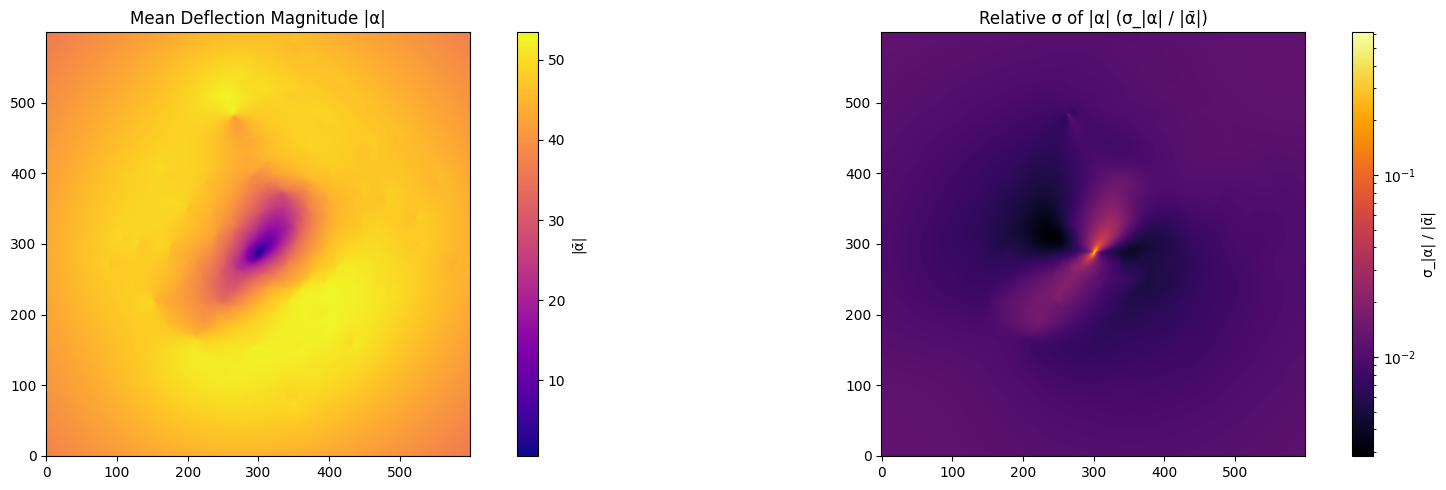

48.97521901215846
0.016347509458670556 0.011576480446868341


In [70]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

im1 = axes[0].imshow(alpha_mean_mag, origin='lower', cmap='plasma')
axes[0].set_title("Mean Deflection Magnitude |α|")
plt.colorbar(im1, ax=axes[0], label="|ᾱ|")

im2 = axes[1].imshow(relative_sigma_alpha, origin='lower', cmap='inferno', norm=LogNorm())
axes[1].set_title("Relative σ of |α| (σ_|α| / |ᾱ|)")
plt.colorbar(im2, ax=axes[1], label="σ_|α| / |ᾱ|")

plt.tight_layout()
plt.show()

print(np.percentile(alpha_mean_mag, 84.0))
print(upper_bound_fraction, upper_bound_fraction_alpha)

In [71]:
# error propagation finally
# getting angular diameter distances
from astropy.cosmology import FlatLambdaCDM
import lenstronomy.Util.constants as const
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

z_s = 3
z_l = 0.3
D_S = cosmo.angular_diameter_distance(z_s).value
D_LS = cosmo.angular_diameter_distance_z1z2(z_l, z_s).value
D_L = cosmo.angular_diameter_distance(z_l).value

# getting D_{\Delta t} = (1+z_l) / c * (D_l*D_s) / D_{ls}
D_dt = (1 + z_l) /const.c / const.day_s * (D_L * D_S) / D_LS * const.Mpc   # in days

print(f"Angular diameter distance D_(Delta t): {D_dt:.4f} days")
# error propagation by sigma_tau = D_{\Delta t} sqrt(|alpha|^2 * sigma_{alpha}^2 + sigma_{psi}^2)
factor = np.sqrt((37.608797219198564**2 * upper_bound_absolute_alpha**2) + (upper_bound_absolute**2))* const.arcsec**2
print(factor)
sigma_tau = D_dt * factor
print(f"Absolute uncertainty in time delay: {sigma_tau} ")


Angular diameter distance D_(Delta t): 1752140827566.9858 days
2.6619982735175955e-09
Absolute uncertainty in time delay: 4664.1958579430075 


Time delay uncertainty map calculated. Shape: (600, 600)


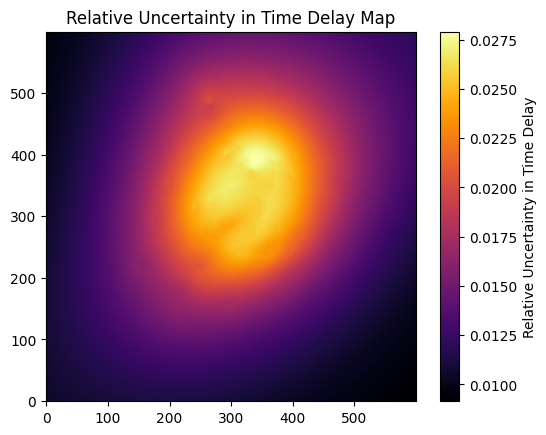

2D array successfully saved to /home/dices/Research/GWlensing_Brian/GCdata/MACS J1149.5+2223/cats copy/hlsp_frontier_model_macs1149_cats_v4_sigma_dt.fits


In [72]:
# generating the uncertainty of time delay map

# alpha map = alpha_mean_mag
alpha_map = alpha_mean_mag

# sigma_alpha map = sigma_abs_alpha
sigma_alpha_map = sigma_abs_alpha

# psi map = psi_mean
psi_map = psi_mean

# sigma_psi map = sigma_abs
sigma_psi_map = sigma_abs

# error propagation by sigma_tau = D_{\Delta t} sqrt(|alpha|^2 * sigma_{alpha}^2 + sigma_{psi}^2)/|0.5*|alpha|^2-psi|
sigma_tau_map = np.sqrt((alpha_map**2 * sigma_alpha_map**2) + (sigma_psi_map**2)) / np.abs(0.5 * alpha_map**2 - psi_map)
print(f"Time delay uncertainty map calculated. Shape: {sigma_tau_map.shape}")

plt.imshow(sigma_tau_map, origin='lower', cmap='inferno')
plt.colorbar(label="Relative Uncertainty in Time Delay")
plt.title("Relative Uncertainty in Time Delay Map")
plt.show()

# store the sigma_tau_map in fits
hdu = fits.PrimaryHDU(sigma_tau_map)

# 3. Write the HDU to a FITS file
file_dir = os.getcwd()
output_fits_file = os.path.join(
        file_dir,
        f'GCdata/{Name}/cats copy/hlsp_frontier_model_{name}_cats_v4_sigma_dt.fits'
    )
hdu.writeto(output_fits_file, overwrite=True)

print(f"2D array successfully saved to {output_fits_file}")

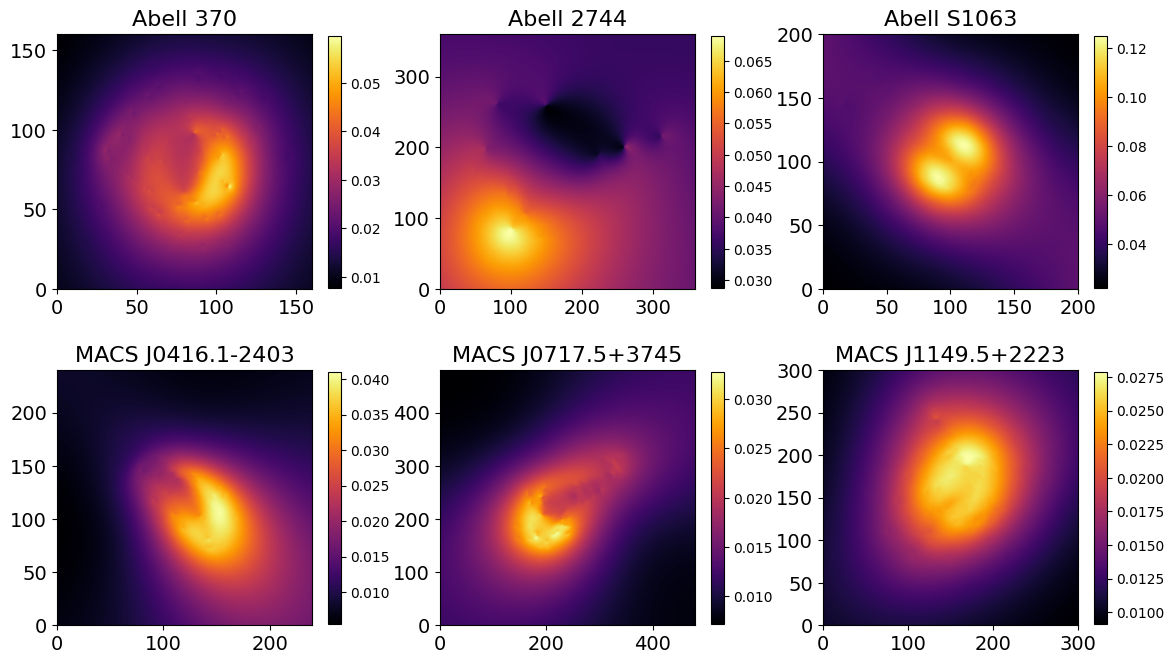

In [11]:
# show the sigma_tau_map of all clusters
Clusters = ["Abell 370", "Abell 2744", "Abell S1063", "MACS J0416.1-2403", "MACS J0717.5+3745", "MACS J1149.5+2223"]
clusters = ["abell370", "abell2744", "abells1063", "macs0416", "macs0717", "macs1149"]
sigma_tau_maps = []
sidepix = [800, 1200, 1000, 800, 600, 600]
pixscale_list = [0.2, 0.3, 0.2, 0.3, 0.8, 0.5]
for i in range(len(Clusters)):
       fits_file = f'/home/dices/Research/GWlensing_Brian/GCdata/{Clusters[i]}/cats copy/hlsp_frontier_model_{clusters[i]}_cats_v4_sigma_dt.fits'
       sigma_tau_map = fits.getdata(fits_file)
       sigma_tau_maps.append(sigma_tau_map)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, sigma_tau_map, Name, sidepix_val, pixscale in zip(axes.flatten(), sigma_tau_maps, Clusters, sidepix, pixscale_list):
       im = ax.imshow(sigma_tau_map, origin='lower', cmap='inferno', extent=[0, sidepix_val*pixscale, 0, sidepix_val*pixscale])
       ax.set_title(f"{Name}", fontsize=16)
       ax.tick_params(axis='both', which='major', labelsize=14)
       fig.colorbar(im, ax=ax, shrink=0.9)



# plot the sample source and image positions to see if they are in the high uncertainty region
# source_positions = (79.38133869128859,78.54673249616513)
# img_pos_true = [119.05981247,  50.24751005,  79.04311009,  78.21502005,
#         78.8115576 ], [71.73848978, 77.35239417, 79.70394538, 57.3211167 , 58.56327652]
# img_pos_wrong_2 = [ 73.39390308, 115.44014224,  89.37707894, 104.47861124,
#        101.0088971 ], [ 72.41300341, 127.08807852, 112.65213177,  98.72007737,
#        100.13697025]
# img_pos_wrong_4 =   [297.58148159, 329.26300995, 314.70122641, 323.7137984 ,
#        320.72247791], [310.96209766, 253.76492267, 277.18707701, 284.71549365,
#        284.62579899]
# img_pos_wrong_5 =  [127.10406665, 166.84080017, 159.69738814, 144.1556969 ,
#        145.7084445 ], [166.20401984, 123.1411192 , 147.49237124, 134.40479188,
#        135.49206894]
# axes[0, 0].scatter(source_positions[0], source_positions[1], c='w', marker='x', s=200, linewidth= 3, label='Source Position')
# axes[0, 0].scatter(img_pos_true[0], img_pos_true[1], c='c', marker='+', s=120, linewidth= 2, label='Image Positions')
# axes[0,2].scatter(img_pos_wrong_2[0], img_pos_wrong_2[1], c='g', marker='+', s=120, linewidth= 2, label='False Image Positions')
# axes[1,1].scatter(img_pos_wrong_4[0], img_pos_wrong_4[1], c='g', marker='+', s=120, linewidth= 2, label='False Image Positions')
# axes[1,2].scatter(img_pos_wrong_5[0], img_pos_wrong_5[1], c='g', marker='+', s=120, linewidth= 2, label='False Image Positions')
# axes[0,0].legend(loc='upper right')
# axes[0,2].legend(loc='upper right')
# axes[1,1].legend(loc='upper right')
# axes[1,2].legend(loc='upper right')
plt.savefig('Report images sem2/new/sigma_tau_map.pdf', bbox_inches='tight')

In [15]:
def check_keyword_in_fits_header(fits_file_path, keyword):
    """
    Opens a FITS file and checks if a specific keyword exists in the header.

    Args:
        fits_file_path (str): The path to the FITS file.
        keyword (str): The keyword to check for in the header.

    Returns:
        bool: True if the keyword exists, False otherwise.
        value: The value of the keyword if it exists, None otherwise.
    """
    try:
        with fits.open(fits_file_path) as hdul:
            # The primary header is typically in the first HDU (Header Data Unit)
            header = hdul[0].header

            if keyword in header:
                return True, header[keyword]
            else:
                return False, None

    except FileNotFoundError:
        print(f"Error: The file '{fits_file_path}' was not found.")
        return False, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return False, None

# --- Example Usage ---
# Replace 'your_lens_map.fits' with the actual path to your FITS file
fits_file = os.path.join(data_path, f"hlsp_frontier_model_{name}_cats-map000_v4_psi.fits")
keyword_to_check = 'BUNIT'

# Create a dummy FITS file for demonstration if you don't have one
# In a real scenario, you would use your own FITS file.
try:
    # Create a dummy numpy array and a primary HDU
    import numpy as np
    dummy_array = np.zeros((10, 10))
    hdu = fits.PrimaryHDU(dummy_array)
    # Add a BUNIT keyword to the header for the example
    hdu.header['BUNIT'] = 'arcsec**2'
    hdu.writeto(fits_file, overwrite=True)
except Exception as e:
    # This will fail if the file can't be written, but the check below will still work if the file exists.
    pass


exists, value = check_keyword_in_fits_header(fits_file, keyword_to_check)

if exists:
    print(f"The keyword '{keyword_to_check}' exists in the header.")
    print(f"The value of '{keyword_to_check}' is: {value}")
else:
    print(f"The keyword '{keyword_to_check}' does not exist in the header.")

The keyword 'BUNIT' exists in the header.
The value of 'BUNIT' is: arcsec**2


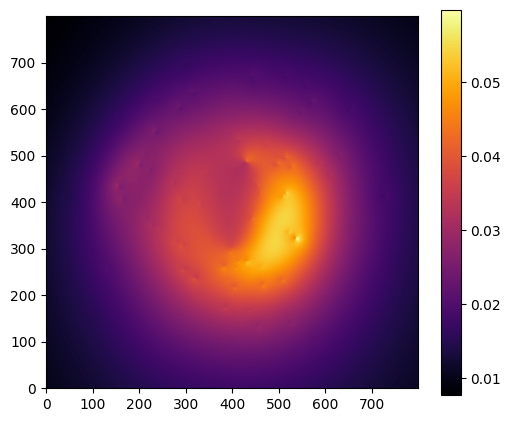

In [12]:
# plot the time delay uncertainty map for checking
# Path to your input and output FITS files
#output_fits_file = '/home/dices/Research/GWlensing_Brian/GCdata/Abell 370/cats copy/hlsp_frontier_model_abell370_cats_v4_sigma_dt.fits'
input_fits_file = output_fits_file

# Open the  FITS file
with fits.open(input_fits_file) as hdul:
    # Assuming the image data is in the primary HDU (index 0)
    hdu = hdul[0]
    wcs = WCS(hdu.header)
    data = hdu.data


fig, ax = plt.subplots(1,1, figsize=(6, 5))
im = ax.imshow(data, origin = 'lower', cmap='inferno')
fig.colorbar(im, ax=ax)
plt.show()